In [25]:
# Import necessary dependencies
import dask.bag as db
import re
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
# Load the main dataframe
docs_df = pd.read_csv("ignore_folder/data/docs_df.csv", low_memory=False)
print(docs_df.shape)
docs_df.head()

(2689088, 7)


,id,title,category,abstract,authors,authors_parsed,update_date
0,0704.0001,Calculation of prompt diphoton production cros...,['hep-ph'],A fully differential calculation in perturba...,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...","[['Balázs', 'C.', ''], ['Berger', 'E. L.', '']...",2008-11-26
1,0704.0002,Sparsity-certifying Graph Decompositions,"['math.CO', 'cs.CG']","We describe a new algorithm, the $(k,\ell)$-...",Ileana Streinu and Louis Theran,"[['Streinu', 'Ileana', ''], ['Theran', 'Louis'...",2008-12-13
2,0704.0003,The evolution of the Earth-Moon system based o...,['physics.gen-ph'],The evolution of Earth-Moon system is descri...,Hongjun Pan,"[['Pan', 'Hongjun', '']]",2008-01-13
3,0704.0004,A determinant of Stirling cycle numbers counts...,['math.CO'],We show that a determinant of Stirling cycle...,David Callan,"[['Callan', 'David', '']]",2007-05-23
4,0704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,"['math.CA', 'math.FA']",In this paper we show how to compute the $\L...,Wael Abu-Shammala and Alberto Torchinsky,"[['Abu-Shammala', 'Wael', ''], ['Torchinsky', ...",2013-10-15


## EDA

In [3]:
# Check for missing values
docs_df.isna().sum()

id                0
title             0
category          0
abstract          0
authors           0
authors_parsed    0
update_date       0
dtype: int64

In [4]:
docs_df["update_date"] = pd.to_datetime(docs_df.loc[:, "update_date"])
docs_df.loc[:, "update_date"].head()

0   2008-11-26
1   2008-12-13
2   2008-01-13
3   2007-05-23
4   2013-10-15
Name: update_date, dtype: datetime64[ns]

In [5]:
# Check the range of dates
dates = docs_df.loc[:, "update_date"].sort_values(ascending=False)
print(f"The date range: {dates.min()} - {dates.max()}")

The date range: 2007-05-23 00:00:00 - 2025-03-14 00:00:00


### Categories

In [6]:
# Extract categories
pattern = r"'(.*?)'"

In [7]:
# Transform categories into a series of lists from series of strings
docs_df["category"] = docs_df.loc[:, "category"].apply(lambda x: re.findall(pattern, x))
docs_df.loc[:, "category"].head()

0              [hep-ph]
1      [math.CO, cs.CG]
2      [physics.gen-ph]
3             [math.CO]
4    [math.CA, math.FA]
Name: category, dtype: object

In [8]:
# Calculate the amount of each unique category
unique_cats_count = docs_df.loc[:, "category"].explode().value_counts()
unique_cats_count = unique_cats_count.reset_index()
unique_cats_count.head()

,category,count
0,cs.LG,210055
1,hep-ph,186039
2,hep-th,172311
3,quant-ph,159114
4,cs.CV,148938


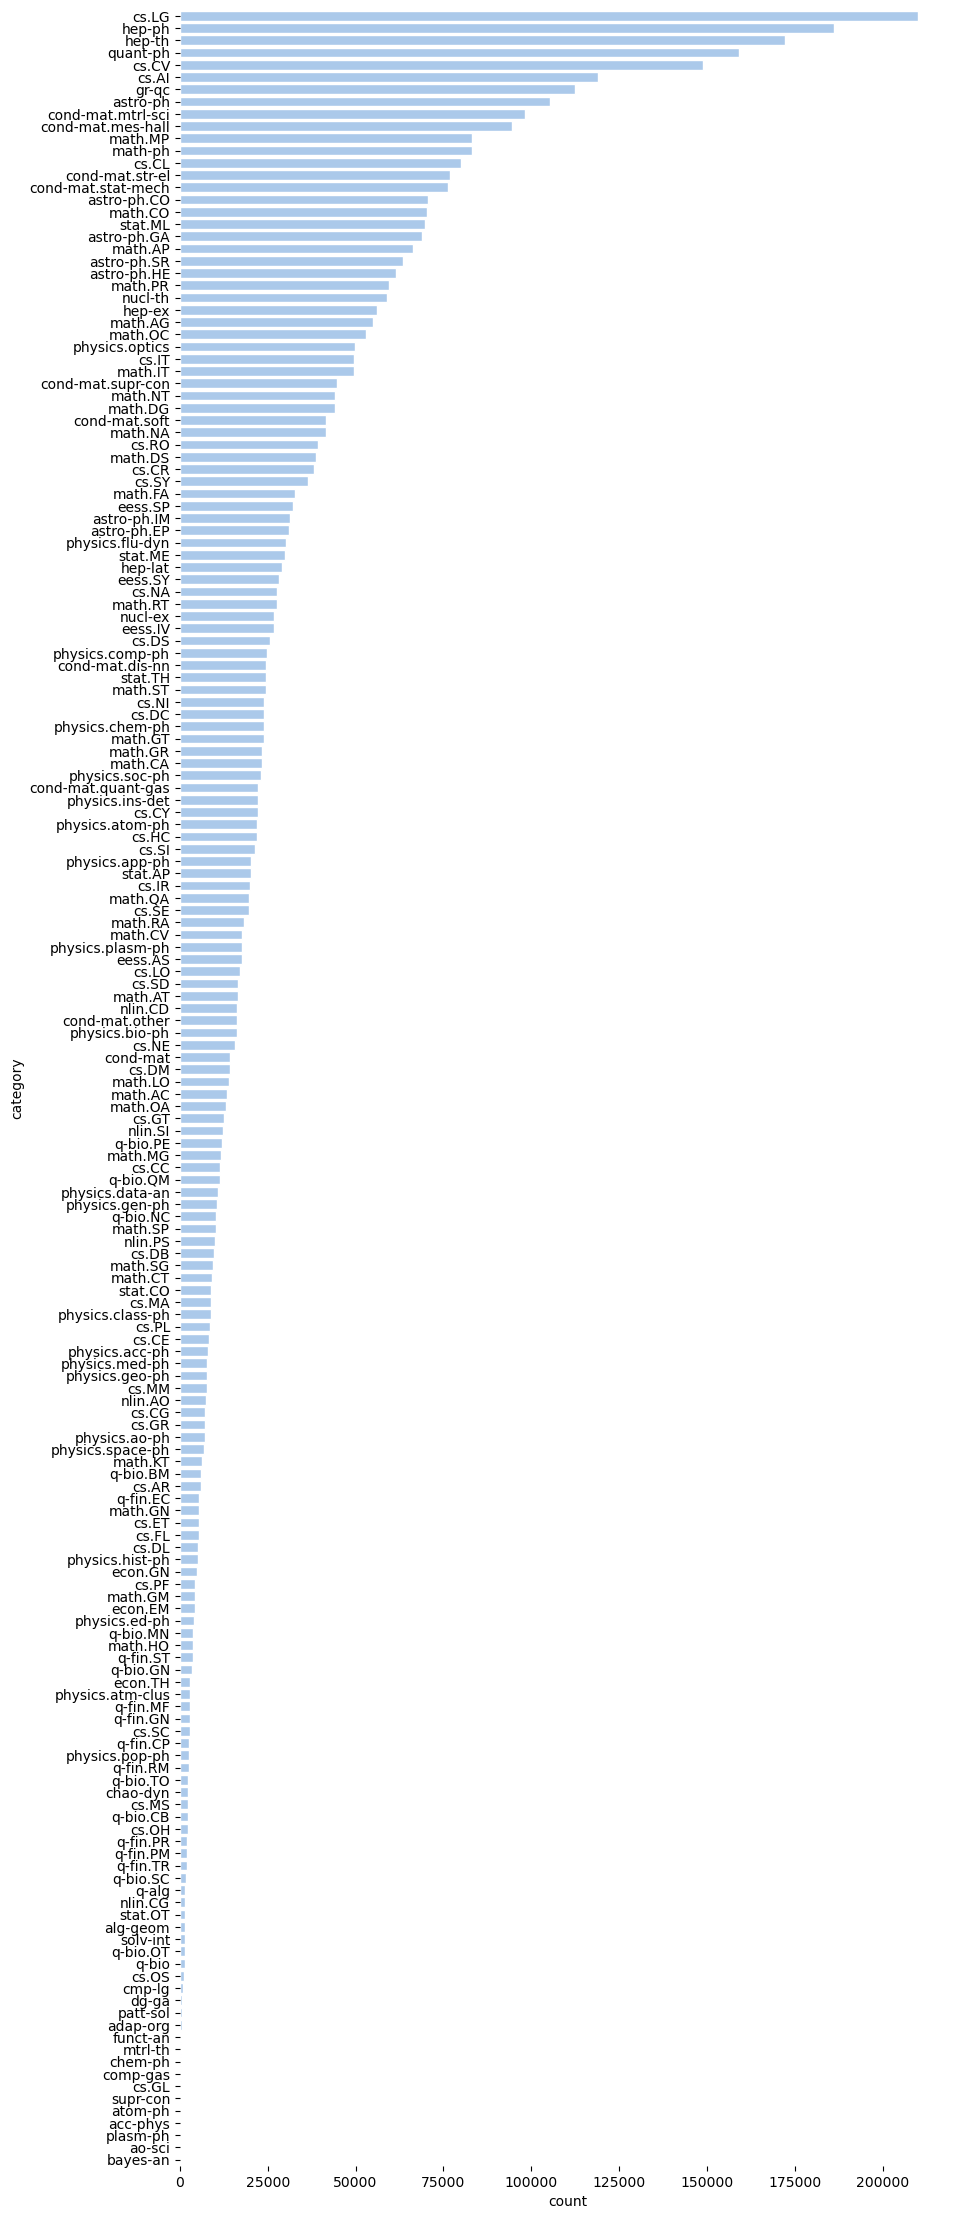

In [9]:
# Plot the distribution for all the categories
fig, ax = plt.subplots(figsize=(10, 28))

sns.set_theme(style="whitegrid", palette="pastel")
sns.barplot(unique_cats_count, x="count", y="category", color="b")
sns.despine(left=True, bottom=True)

As you can see, we have a pretty large amount of categories. We have 2 possible choices here:
- Combine less popular categories into one (e.g. "unknown") via threshold;
- Bin this variable with the respect to the target variable (e.g. [OptBinning](https://gnpalencia.org/optbinning/)).

### Authors

In [10]:
docs_df.loc[:, ["authors", "authors_parsed"]].head()

,authors,authors_parsed
0,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...","[['Balázs', 'C.', ''], ['Berger', 'E. L.', '']..."
1,Ileana Streinu and Louis Theran,"[['Streinu', 'Ileana', ''], ['Theran', 'Louis'..."
2,Hongjun Pan,"[['Pan', 'Hongjun', '']]"
3,David Callan,"[['Callan', 'David', '']]"
4,Wael Abu-Shammala and Alberto Torchinsky,"[['Abu-Shammala', 'Wael', ''], ['Torchinsky', ..."


In [11]:
docs_df.loc[0, "authors"]

"C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan"

In [12]:
docs_df.loc[0, "authors_parsed"]

"[['Balázs', 'C.', ''], ['Berger', 'E. L.', ''], ['Nadolsky', 'P. M.', ''], ['Yuan', 'C. -P.', '']]"

From my point of view, it is better to use `authors` variable to extract the lists of authors. \
**Assumption**: each pair of author names is separated either by "*,*" or "*and*".

In [13]:
# Apply RegEx to extract relevant information from "authors" column
pattern = r",\s*|\s+and\s+"

docs_df["authors"] = docs_df.loc[:, "authors"].apply(lambda x: re.split(pattern, x))

In [14]:
unique_authors_amount = docs_df.loc[:, "authors"].explode().value_counts()
unique_authors_amount.head(40)

authors
2)                   15012
Italy                 7169
3)                    6536
USA                   5608
Germany               4981
Germany)              4317
Astronomy             3746
4)                    3616
France                3572
USA)                  3558
Spain                 3533
Italy)                3477
et al                 3074
Y. Zhang              2644
France)               2535
UK                    2504
Russia)               2402
2                     2351
UK)                   2287
5)                    2206
Yang Liu              1987
CNRS                  1900
Y. Wang               1893
J. Wang               1891
India)                1888
Z. Wang               1701
Wei Wang              1693
Y. Li                 1680
Moscow                1641
6)                    1500
Russia                1497
Lei Zhang             1486
X. Liu                1478
Takashi Taniguchi     1454
Y. Gao                1437
Japan                 1414
Spain)              

As you can see, the result contains a lot of single words, countries, etc. \
So, we may remove them.

In [19]:
del unique_authors_amount

unique_authors_amount = docs_df.loc[:, "authors"].apply(lambda x: [i for i in x if len(i.split()) > 1]).explode().value_counts()
print(unique_authors_amount.shape[0])
unique_authors_amount.head(20)

2672167


authors
et al                  3074
Y. Zhang               2644
Yang Liu               1987
Y. Wang                1893
J. Wang                1891
Z. Wang                1701
Wei Wang               1693
Y. Li                  1680
Lei Zhang              1486
X. Liu                 1478
Takashi Taniguchi      1454
Y. Gao                 1437
Y. Liu                 1400
Kenji Watanabe         1399
CMS Collaboration      1348
Z. Xu                  1343
Wei Zhang              1321
L. Zhang               1311
ATLAS Collaboration    1286
C. Li                  1282
Name: count, dtype: int64

As you can see, we have quite a lot of authors. Even "et al." is here. What a legendary man. \
It is quite hard to transform this variable into a categorical one. Moreover, it is almost pointless to search h-index for each author due to lack of full name in most cases.

### Update date

In [24]:
# Calculate the amount of each date in our dataset
date_counts = docs_df.loc[:, "update_date"].value_counts().sort_index()
print(date_counts.shape[0])
date_counts.head(10)

5334


update_date
2007-05-23    129984
2007-05-24        45
2007-05-25        64
2007-05-28        30
2007-05-29        58
2007-05-30        40
2007-05-31        36
2007-06-01        59
2007-06-04        51
2007-06-05        69
Name: count, dtype: int64

In [ ]:
# Aggregate by months
date_counts = docs_df.resample("ME", on="update_date").size()
date_counts

update_date
2007-05-31    130257
2007-06-30      3024
2007-07-31      2653
2007-08-31      1769
2007-09-30      1862
               ...  
2024-11-30     27353
2024-12-31     32070
2025-01-31     29310
2025-02-28     34472
2025-03-31     20092
Freq: ME, Length: 215, dtype: int64

In [42]:
# Plot the distribution of dates
fig = px.bar(
    x=date_counts.index,
    y=date_counts.values,
    labels={"x": "Date", "y": "Number of Entries"},
    title="Dates distribution over time"
)

fig.update_xaxes(
    dtick="M4",
    tickformat="%b %Y",
    tickangle=45,
)

fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Number of Entries",
    template="plotly_white"
)

fig.show()

In [41]:
date_counts.sort_values(ascending=False)

update_date
2007-05-31    130257
2009-11-30    118157
2015-06-30     79371
2009-10-31     65646
2015-05-31     51297
               ...  
2008-08-31      1900
2007-09-30      1862
2007-12-31      1857
2008-03-31      1838
2007-08-31      1769
Length: 215, dtype: int64

The amount of publications per month. However, we can see some outliers in our data:
- The first one may mean that quite a lot of publications were published/updated before 2007-05-23;
- The second one occured during the period from the beginning of October to the end of November of 2009;
- The third one occured during the period from the beginning of May to the end June of 2015.